In [1]:
import json, os, pandas, pathlib, peft, torch, transformers

from torch.utils.data import Dataset, DataLoader
from lightning import LightningModule, LightningDataModule, Trainer
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import EarlyStopping
from transformers import AutoModelForCausalLM, AutoTokenizer

torch.set_float32_matmul_precision('high')

base_model_name = "gpt2"
data_path = "data/train.jsonl"

In [2]:
def get_response(model, tokenizer, prompt):
    inputs = tokenizer(prompt, return_tensors="pt", padding=True)
    input_ids = inputs["input_ids"].to(model.device)
    attention_mask = inputs["attention_mask"].to(model.device)
    output = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_new_tokens=100,
        do_sample=True,
        temperature=0.7,
        top_p=0.8,
        top_k=50,
        repetition_penalty=1.2,
        pad_token_id=tokenizer.eos_token_id,
    )
    text = tokenizer.decode(output[0], skip_special_tokens=True)
    return text[len(prompt):].lstrip()

In [15]:
base_model = AutoModelForCausalLM.from_pretrained(base_model_name, dtype="auto", device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = tokenizer.eos_token
print("Loaded a pretrained model of type", type(base_model))

Loaded a pretrained model of type <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'>


In [4]:
prompt = "What is a board game?"
response = get_response(base_model, tokenizer, prompt)
print(response)

Aboard games are often played in small groups of friends or family. In some cases, they can be held together by an action-packed story and play as one long narrative adventure through the world around you (or both). It's not uncommon to see boards for fun at home on your next vacation! The most common way I've seen this happen was when my parents were playing Board Game Day with me during our first year attending college – we'd sit down while he did his homework until it


In [5]:
class JsonlDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_len=256):
        self.samples = []
        self.tokenizer = tokenizer
        self.max_len = max_len
        with pathlib.Path(file_path).open() as f:
            for line in f:
                obj = json.loads(line)
                self.samples.append((obj["prompt"], obj["completion"]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        prompt, completion = self.samples[idx]
        tokenized = self.tokenizer(prompt + completion, truncation=True, max_length=self.max_len)
        input_ids = torch.tensor(tokenized["input_ids"])
        attention_mask = torch.tensor(tokenized["attention_mask"])
        labels = input_ids.clone()
        prompt_len = len(self.tokenizer(prompt, add_special_tokens=False)["input_ids"])
        labels[:prompt_len] = -100 # For every prompt token set the label to -100, so it is not used in loss calculation.
        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}
  
dataset = JsonlDataset(data_path, tokenizer)
print("Created a dataset with", len(dataset), "samples")

Created a dataset with 74 samples


The collate function ensures that all items in a batch are of equal length by padding them with pad tokens. Additionally, for each pad token it sets the attention mask to 0 and its label to -100 (meaning irrelevant).

In [6]:
def collate(batch):
    input_ids = [b["input_ids"] for b in batch]
    attention_mask = [b["attention_mask"] for b in batch]
    labels = [b["labels"] for b in batch]
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True, padding_value=0)
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=-100)
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

class TextDataModule(LightningDataModule):    
    def __init__(self, data, split=[.8, .2], batch_size=4, num_workers=0):
        super().__init__()
        self.data = data
        self.split = split
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        torch.manual_seed(42)
        self.train, self.val = torch.utils.data.random_split(self.data, self.split)

    def train_dataloader(self):
        return DataLoader(self.train, collate_fn=collate, shuffle=True, batch_size=self.batch_size, num_workers=self.num_workers)
    
    def val_dataloader(self):
        return DataLoader(self.val, collate_fn=collate, batch_size=self.batch_size, num_workers=self.num_workers)

datamodule = TextDataModule(dataset)

In [7]:

class LoRA(LightningModule):
    def __init__(self, base_model, learning_rate=3e-5, weight_decay=0.01, warmup_steps=300):
        super().__init__()
        self.save_hyperparameters(ignore=["base_model"])
        model = peft.prepare_model_for_kbit_training(base_model)
        lora_cfg = peft.LoraConfig(
            r=16,
            lora_alpha=32,
            target_modules=["c_attn", "c_proj"],  # typical for GPT‑style models
            lora_dropout=0.05,
            bias="none",
            fan_in_fan_out=True,
        )
        self.model = peft.get_peft_model(model, lora_cfg)

    def forward(self, **batch):
        return self.model(**batch)

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        return outputs.loss
    
    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        val_loss = outputs.loss
        self.log("val_loss", val_loss, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.hparams.learning_rate, weight_decay=self.hparams.weight_decay)
        scheduler = transformers.get_linear_schedule_with_warmup(optimizer, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=self.trainer.estimated_stepping_batches)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "interval": "step"}}

lora = LoRA(base_model)

In [8]:
logger = CSVLogger(save_dir=".")
stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)
trainer = Trainer(max_epochs=-1, logger=logger, callbacks=[stop])
trainer.fit(lora, datamodule=datamodule)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params | Mode  | FLOPs
----------------------------------------------------
0 | model | PeftModel | 126 M  | train | 0    
----------------------------------------------------
1.6 M     Trainable params
124 M     Non-trainable params
126 M     Total params
504.247   Total estimated model params size (MB)
362       Modules in train mode
164       Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Bas\AppData\Local\Programs\Python\Python314\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.
c:\Users\Bas\AppData\Local\Programs\Python\Python314\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\Bas\AppData\Local\Programs\Python\Python314\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:317: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower va

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

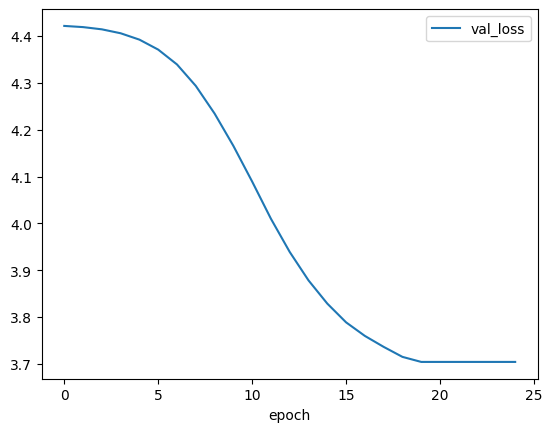

In [9]:
metrics = pandas.read_csv(os.path.join(trainer.log_dir, "metrics.csv"))
loss_metrics = metrics[["epoch", "val_loss"]].set_index("epoch")
plot = loss_metrics.plot()

In [10]:
prompt = "What is a board game?"
response = get_response(base_model, tokenizer, prompt)
print(response)

A boardgame refers to games that introduce new mechanics or challenge players through strategic play. Players compete for control of the battlefield, expanding their strategy and building momentum by rewarding decision-making with innovative strategies such as surprise attacks; expansion effects create unique challenges throughout the campaign setting.[1][2] A boardgames design provides flexibility in challenging settings while also fostering replayability across expansions.[3],[4],[5].Designers often include multiple layers of complexity into varied gameplay styles,[6–8](e
